In [4]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
import os
import pandas as pd
import numpy as np
from tensorflow.keras.optimizers import Adam

##############################################
# Parameters & Setup
##############################################
seq_len = 10
embedding_dim = 8
batch_size = 64
data_dir = 'split_data_parquet'

player_columns = [
    "OFF_PLAYER1_ID", "OFF_PLAYER2_ID", "OFF_PLAYER3_ID", "OFF_PLAYER4_ID", "OFF_PLAYER5_ID",
    "DEF_PLAYER1_ID", "DEF_PLAYER2_ID", "DEF_PLAYER3_ID", "DEF_PLAYER4_ID", "DEF_PLAYER5_ID"
]

main_out_column = "OUTCOME"
second_chance_column = "SECOND_CHANCE"

# These are the role ID columns given as actual player IDs
role_id_cols = ["SHOOTER_ID", "ASSISTER_ID", "BLOCKER_ID", "STEALER_ID", "REBOUNDER_ID", "TURNOVER_ID"]

train_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('train_') and f.endswith('.parquet')])
val_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('val_') and f.endswith('.parquet')])
test_files = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.startswith('test_') and f.endswith('.parquet')])

##############################################
# Build Player ID Mapping
##############################################
def gather_unique_player_ids(files, player_cols):
    unique_ids = set()
    for fpath in files:
        print(f"Scanning file for unique IDs: {fpath}")
        df = pd.read_parquet(fpath, columns=player_cols)  # load only player columns
        df = df.dropna(subset=player_cols)
        for col in player_cols:
            unique_ids.update(df[col].dropna().astype(int).unique())
    return unique_ids

all_files = train_files + val_files + test_files
all_unique_ids = gather_unique_player_ids(all_files, player_columns)

unique_players = np.sort(list(all_unique_ids))
player_to_index = {p: i for i, p in enumerate(unique_players)}
v = len(unique_players)
print(f"Number of unique players: {v}")
print("Example mapping:", list(player_to_index.items())[:10])

##############################################
# Transformer Encoder Block Definition
##############################################
def transformer_encoder(inputs, num_heads=2, ff_dim=32, dropout_rate=0.1):
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(inputs, inputs)
    attn_output = layers.Dropout(dropout_rate)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(inputs + attn_output)

    ffn = layers.Dense(ff_dim, activation='relu')(out1)
    ffn = layers.Dense(embedding_dim)(ffn)
    ffn = layers.Dropout(dropout_rate)(ffn)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    return out2

##############################################
# Define Named Functions for Lambdas
##############################################
def slice_offense(t):
    return t[:, :5, :]

def slice_defense(t):
    return t[:, 5:, :]

def mean_axis_1(t):
    return tf.reduce_mean(t, axis=1)

##############################################
# Model Definition Using Transformer
##############################################
input_players = Input(shape=(seq_len,), dtype='int32', name='players_input')
player_embedding = layers.Embedding(input_dim=v, output_dim=embedding_dim, name='player_embedding')(input_players)

x = transformer_encoder(player_embedding, num_heads=2, ff_dim=32, dropout_rate=0.1)

offense_emb = layers.Lambda(slice_offense, name='offense_slice')(x)
defense_emb = layers.Lambda(slice_defense, name='defense_slice')(x)

off_mean = layers.Lambda(mean_axis_1, name='off_mean')(offense_emb)
def_mean = layers.Lambda(mean_axis_1, name='def_mean')(defense_emb)

concat = layers.Concatenate(name='concat')([off_mean, def_mean])
hidden = layers.Dense(128, activation='relu', name='hidden')(concat)

main_out = layers.Dense(14, activation='softmax', name='main_out')(hidden)
second_chance_out = layers.Dense(1, activation='sigmoid', name='second_chance_out')(hidden)

# For roles: shooter, assister, blocker, stealer, rebounder, turnover
# We'll mean-pool all players for roles
all_mean = layers.Lambda(mean_axis_1, name='all_mean')(x)
roles_hidden = layers.Dense(64, activation='relu', name='roles_hidden')(all_mean)

# Each role output: 10 classes (one for each of the 10 players on the floor)
shooter_out = layers.Dense(seq_len, activation='softmax', name='shooter_out')(roles_hidden)
assister_out = layers.Dense(seq_len, activation='softmax', name='assister_out')(roles_hidden)
blocker_out = layers.Dense(seq_len, activation='softmax', name='blocker_out')(roles_hidden)
stealer_out = layers.Dense(seq_len, activation='softmax', name='stealer_out')(roles_hidden)
rebounder_out = layers.Dense(seq_len, activation='softmax', name='rebounder_out')(roles_hidden)
turnover_out = layers.Dense(seq_len, activation='softmax', name='turnover_out')(roles_hidden)

model = Model(inputs=input_players, outputs=[
    main_out, second_chance_out,
    shooter_out, assister_out, blocker_out, stealer_out, rebounder_out, turnover_out
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        'main_out': 'categorical_crossentropy',
        'second_chance_out': 'binary_crossentropy',
        'shooter_out': 'categorical_crossentropy',
        'assister_out': 'categorical_crossentropy',
        'blocker_out': 'categorical_crossentropy',
        'stealer_out': 'categorical_crossentropy',
        'rebounder_out': 'categorical_crossentropy',
        'turnover_out': 'categorical_crossentropy'
    },
    metrics={
        'main_out': 'accuracy',
        'second_chance_out': 'accuracy',
        'shooter_out': 'accuracy',
        'assister_out': 'accuracy',
        'blocker_out': 'accuracy',
        'stealer_out': 'accuracy',
        'rebounder_out': 'accuracy',
        'turnover_out': 'accuracy'
    }
)

model.summary()

##############################################
# Utility Functions for tf.data Pipeline
##############################################
def one_hot_role_from_id(role_id_array, row_players):
    num_samples = len(role_id_array)
    arr = np.zeros((num_samples, 10), dtype='float32')
    for i, rid in enumerate(role_id_array):
        if pd.isnull(rid):
            continue
        rid = int(rid)
        idx_pos = np.where(row_players[i] == rid)[0]
        if len(idx_pos) > 0:
            arr[i, idx_pos[0]] = 1.0
    return arr

def shard_generator(file_list, main_col, sc_col, mapping):
    for fpath in file_list:
        print(f"Loading shard: {fpath}")
        df = pd.read_parquet(fpath)
        df = df.dropna(subset=player_columns)
        df_players_original = df[player_columns].copy()

        # Convert to int
        for col in player_columns:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

        # Outcome one-hot
        categories = sorted(df[main_col].unique())
        cat_to_idx = {cat: i for i, cat in enumerate(categories)}

        num_samples = len(df)
        y_main = np.zeros((num_samples, 14), dtype='float32')
        for i, val in enumerate(df[main_col]):
            class_idx = cat_to_idx[val]
            y_main[i, class_idx] = 1.0

        y_sc = df[sc_col].astype(int).values.reshape(-1, 1)

        # Role IDs
        shooter_ids = df["SHOOTER_ID"]
        assister_ids = df["ASSISTER_ID"]
        blocker_ids = df["BLOCKER_ID"]
        stealer_ids = df["STEALER_ID"]
        rebounder_ids = df["REBOUNDER_ID"]
        turnover_ids = df["TURNOVER_ID"]

        # Drop target columns
        df.drop(columns=[main_col, sc_col, "SHOOTER_ID", "ASSISTER_ID", "BLOCKER_ID", "STEALER_ID", "REBOUNDER_ID", "TURNOVER_ID"], inplace=True)

        row_players_original = df_players_original[player_columns].values
        y_shooter = one_hot_role_from_id(shooter_ids, row_players_original)
        y_assister = one_hot_role_from_id(assister_ids, row_players_original)
        y_blocker = one_hot_role_from_id(blocker_ids, row_players_original)
        y_stealer = one_hot_role_from_id(stealer_ids, row_players_original)
        y_rebounder = one_hot_role_from_id(rebounder_ids, row_players_original)
        y_turnover = one_hot_role_from_id(turnover_ids, row_players_original)

        # Map player IDs now
        for c in player_columns:
            df[c] = df[c].map(mapping)
        X = df[player_columns].values.astype(np.int32)

        for i in range(num_samples):
            yield X[i], (y_main[i], y_sc[i], y_shooter[i], y_assister[i], y_blocker[i], y_stealer[i], y_rebounder[i], y_turnover[i])

def create_dataset(file_list, main_col, sc_col, batch_size, mapping, shuffle_buffer=10000):
    ds = tf.data.Dataset.from_generator(
        lambda: shard_generator(file_list, main_col, sc_col, mapping),
        output_types=(tf.int32, (tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.float32)),
        output_shapes=((seq_len,), ((14,), (1,), (10,), (10,), (10,), (10,), (10,), (10,)))
    )

    ds = ds.shuffle(shuffle_buffer)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_files, main_out_column, second_chance_column, batch_size, player_to_index)
val_ds = create_dataset(val_files, main_out_column, second_chance_column, batch_size, player_to_index)
test_ds = create_dataset(test_files, main_out_column, second_chance_column, batch_size, player_to_index)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

model.evaluate(test_ds)

Scanning file for unique IDs: split_data_parquet/train_000.parquet
Scanning file for unique IDs: split_data_parquet/train_001.parquet
Scanning file for unique IDs: split_data_parquet/train_002.parquet
Scanning file for unique IDs: split_data_parquet/train_003.parquet
Scanning file for unique IDs: split_data_parquet/train_004.parquet
Scanning file for unique IDs: split_data_parquet/train_005.parquet
Scanning file for unique IDs: split_data_parquet/train_006.parquet
Scanning file for unique IDs: split_data_parquet/train_007.parquet
Scanning file for unique IDs: split_data_parquet/train_008.parquet
Scanning file for unique IDs: split_data_parquet/train_009.parquet
Scanning file for unique IDs: split_data_parquet/val_000.parquet
Scanning file for unique IDs: split_data_parquet/val_001.parquet
Scanning file for unique IDs: split_data_parquet/test_000.parquet
Scanning file for unique IDs: split_data_parquet/test_001.parquet
Number of unique players: 961
Example mapping: [(1713, 0), (2544, 1)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ players_input       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_embedding    │ (None, 10, 8)     │      7,688 │ players_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 8)     │        568 │ player_embedding… │
│ (MultiHeadAttentio… │                   │            │ player_embedding… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 10, 8)     │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 10, 8)     │          0 │ player_embedding… │
│                     │                   │            │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 8)     │         16 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10, 32)    │        288 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10, 8)     │        264 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 10, 8)     │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 10, 8)     │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 8)     │         16 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ offense_slice       │ (None, 5, 8)      │          0 │ layer_normalizat… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ defense_slice       │ (None, 5, 8)      │          0 │ layer_normalizat… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ off_mean (Lambda)   │ (None, 8)         │          0 │ offense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ def_mean (Lambda)   │ (None, 8)         │          0 │ defense_slice[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 16)        │          0 │ off_mean[0][0],   │
│ (Concatenate)       │                   │            │ def_mean[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ all_mean (Lambda)   │ (None, 8)         │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ hidden (Dense)      │ (None, 128)       │      2,176 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ roles_hidden        │ (None, 64)        │        576 │ all_mean[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 17,427 (68.07 KB)

 Trainable params: 17,427 (68.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
Loading shard: split_data_parquet/train_000.parquet
   1755/Unknown 16s 7ms/step - assister_out_accuracy: 0.0037 - assister_out_loss: 0.5153 - blocker_out_accuracy: 0.6063 - blocker_out_loss: 0.0924 - loss: 6.0414 - main_out_accuracy: 0.3041 - main_out_loss: 2.2122 - rebounder_out_accuracy: 0.0344 - rebounder_out_loss: 0.8832 - second_chance_out_accuracy: 0.8788 - second_chance_out_loss: 0.4034 - shooter_out_accuracy: 0.2062 - shooter_out_loss: 1.5506 - stealer_out_accuracy: 0.0117 - stealer_out_loss: 0.1285 - turnover_out_accuracy: 0.0769 - turnover_out_loss: 0.2557Loading shard: split_data_parquet/train_001.parquet
   3668/Unknown 29s 7ms/step - assister_out_accuracy: 0.0022 - assister_out_loss: 0.5077 - blocker_out_accuracy: 0.7240 - blocker_out_loss: 0.0941 - loss: 5.8525 - main_out_accuracy: 0.3289 - main_out_loss: 2.1498 - rebounder_out_accuracy: 0.0417 - rebounder_out_loss: 0.8756 - second_chance_out_accuracy: 0.8831 - second_chance_out_loss: 0.3807 - shooter_out_accu

2024-12-09 23:43:50.899968: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_000.parquet
Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - assister_out_accuracy: 0.0021 - assister_out_loss: 0.4643 - blocker_out_accuracy: 0.8875 - blocker_out_loss: 0.0952 - loss: 5.5892 - main_out_accuracy: 0.3532 - main_out_loss: 2.0852 - rebounder_out_accuracy: 0.0514 - rebounder_out_loss: 0.8578 - second_chance_out_accuracy: 0.8867 - second_chance_out_loss: 0.3590 - shooter_out_accuracy: 0.2308 - shooter_out_loss: 1.3594 - stealer_out_accuracy: 0.0120 - stealer_out_loss: 0.1238 - turnover_out_accuracy: 0.0194 - turnover_out_loss: 0.2445 - val_assister_out_accuracy: 0.8394 - val_assister_out_loss: 0.3968 - val_blocker_out_accuracy: 0.9625 - val_blocker_out_loss: 0.0893 - val_loss: 5.4162 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0628 - val_rebounder_out_accuracy: 0.0546 - val_rebounder_out_loss: 0.8497 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3521

2024-12-09 23:44:05.607850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1756/19153 ━━━━━━━━━━━━━━━━━━━━ 1:58 7ms/step - assister_out_accuracy: 0.1652 - assister_out_loss: 0.3938 - blocker_out_accuracy: 0.9626 - blocker_out_loss: 0.0894 - loss: 5.3941 - main_out_accuracy: 0.3599 - main_out_loss: 2.0625 - rebounder_out_accuracy: 0.0571 - rebounder_out_loss: 0.8372 - second_chance_out_accuracy: 0.8892 - second_chance_out_loss: 0.3484 - shooter_out_accuracy: 0.2063 - shooter_out_loss: 1.3258 - stealer_out_accuracy: 0.0112 - stealer_out_loss: 0.1158 - turnover_out_accuracy: 0.0891 - turnover_out_loss: 0.2213Loading shard: split_data_parquet/train_001.parquet
 3673/19153 ━━━━━━━━━━━━━━━━━━━━ 1:46 7ms/step - assister_out_accuracy: 0.1726 - assister_out_loss: 0.3917 - blocker_out_accuracy: 0.9627 - blocker_out_loss: 0.0891 - loss: 5.3983 - main_out_accuracy: 0.3605 - main_out_loss: 2.0634 - rebounder_out_accuracy: 0.0569 - rebounder_out_loss: 0.8394 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 

2024-12-09 23:46:14.630831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - assister_out_accuracy: 0.1819 - assister_out_loss: 0.3841 - blocker_out_accuracy: 0.9624 - blocker_out_loss: 0.0886 - loss: 5.3982 - main_out_accuracy: 0.3614 - main_out_loss: 2.0635 - rebounder_out_accuracy: 0.0567 - rebounder_out_loss: 0.8439 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3509 - shooter_out_accuracy: 0.2083 - shooter_out_loss: 1.3312 - stealer_out_accuracy: 0.0120 - stealer_out_loss: 0.1160 - turnover_out_accuracy: 0.0999 - turnover_out_loss: 0.2199 - val_assister_out_accuracy: 0.0394 - val_assister_out_loss: 0.3691 - val_blocker_out_accuracy: 0.9625 - val_blocker_out_loss: 0.0840 - val_loss: 5.3636 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0629 - val_rebounder_out_accuracy: 0.0589 - val_rebounder_out_loss: 0.8484 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3521 - val_shooter_out_accuracy: 0.1627 - val_shooter_

2024-12-09 23:46:29.434625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1753/19153 ━━━━━━━━━━━━━━━━━━━━ 2:00 7ms/step - assister_out_accuracy: 0.2018 - assister_out_loss: 0.3653 - blocker_out_accuracy: 0.9626 - blocker_out_loss: 0.0848 - loss: 5.3704 - main_out_accuracy: 0.3609 - main_out_loss: 2.0607 - rebounder_out_accuracy: 0.0579 - rebounder_out_loss: 0.8436 - second_chance_out_accuracy: 0.8894 - second_chance_out_loss: 0.3482 - shooter_out_accuracy: 0.2073 - shooter_out_loss: 1.3459 - stealer_out_accuracy: 0.0114 - stealer_out_loss: 0.1126 - turnover_out_accuracy: 0.2196 - turnover_out_loss: 0.2093Loading shard: split_data_parquet/train_001.parquet
 3673/19153 ━━━━━━━━━━━━━━━━━━━━ 1:46 7ms/step - assister_out_accuracy: 0.1996 - assister_out_loss: 0.3630 - blocker_out_accuracy: 0.9627 - blocker_out_loss: 0.0844 - loss: 5.3757 - main_out_accuracy: 0.3611 - main_out_loss: 2.0634 - rebounder_out_accuracy: 0.0576 - rebounder_out_loss: 0.8454 - second_chance_out_accuracy: 0.8889 - second_chance_out_loss: 

2024-12-09 23:48:39.161630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 145s 8ms/step - assister_out_accuracy: 0.1943 - assister_out_loss: 0.3583 - blocker_out_accuracy: 0.9624 - blocker_out_loss: 0.0842 - loss: 5.3835 - main_out_accuracy: 0.3615 - main_out_loss: 2.0647 - rebounder_out_accuracy: 0.0573 - rebounder_out_loss: 0.8506 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3510 - shooter_out_accuracy: 0.2061 - shooter_out_loss: 1.3538 - stealer_out_accuracy: 0.0120 - stealer_out_loss: 0.1126 - turnover_out_accuracy: 0.2164 - turnover_out_loss: 0.2083 - val_assister_out_accuracy: 0.8394 - val_assister_out_loss: 0.3466 - val_blocker_out_accuracy: 0.9625 - val_blocker_out_loss: 0.0824 - val_loss: 5.3767 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0682 - val_rebounder_out_accuracy: 0.0568 - val_rebounder_out_loss: 0.8502 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3553 - val_shooter_out_accuracy: 0.1606 - val_shooter_

2024-12-09 23:48:54.182431: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1752/19153 ━━━━━━━━━━━━━━━━━━━━ 1:59 7ms/step - assister_out_accuracy: 0.2018 - assister_out_loss: 0.3464 - blocker_out_accuracy: 0.9625 - blocker_out_loss: 0.0811 - loss: 5.3676 - main_out_accuracy: 0.3601 - main_out_loss: 2.0648 - rebounder_out_accuracy: 0.0572 - rebounder_out_loss: 0.8515 - second_chance_out_accuracy: 0.8897 - second_chance_out_loss: 0.3479 - shooter_out_accuracy: 0.2060 - shooter_out_loss: 1.3682 - stealer_out_accuracy: 0.0113 - stealer_out_loss: 0.1088 - turnover_out_accuracy: 0.2631 - turnover_out_loss: 0.1989Loading shard: split_data_parquet/train_001.parquet
 3667/19153 ━━━━━━━━━━━━━━━━━━━━ 1:45 7ms/step - assister_out_accuracy: 0.1980 - assister_out_loss: 0.3455 - blocker_out_accuracy: 0.9626 - blocker_out_loss: 0.0807 - loss: 5.3775 - main_out_accuracy: 0.3607 - main_out_loss: 2.0661 - rebounder_out_accuracy: 0.0572 - rebounder_out_loss: 0.8539 - second_chance_out_accuracy: 0.8889 - second_chance_out_loss: 

2024-12-09 23:51:02.603446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 143s 7ms/step - assister_out_accuracy: 0.1953 - assister_out_loss: 0.3432 - blocker_out_accuracy: 0.9598 - blocker_out_loss: 0.0805 - loss: 5.3950 - main_out_accuracy: 0.3615 - main_out_loss: 2.0662 - rebounder_out_accuracy: 0.0580 - rebounder_out_loss: 0.8601 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3512 - shooter_out_accuracy: 0.2061 - shooter_out_loss: 1.3848 - stealer_out_accuracy: 0.0120 - stealer_out_loss: 0.1098 - turnover_out_accuracy: 0.2399 - turnover_out_loss: 0.1993 - val_assister_out_accuracy: 0.0419 - val_assister_out_loss: 0.3347 - val_blocker_out_accuracy: 0.9624 - val_blocker_out_loss: 0.0764 - val_loss: 5.5348 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0772 - val_rebounder_out_accuracy: 0.0568 - val_rebounder_out_loss: 0.8869 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3521 - val_shooter_out_accuracy: 0.3523 - val_shooter_

2024-12-09 23:51:17.324646: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1751/19153 ━━━━━━━━━━━━━━━━━━━━ 1:54 7ms/step - assister_out_accuracy: 0.2147 - assister_out_loss: 0.3384 - blocker_out_accuracy: 0.8935 - blocker_out_loss: 0.0770 - loss: 5.4336 - main_out_accuracy: 0.3600 - main_out_loss: 2.0652 - rebounder_out_accuracy: 0.0587 - rebounder_out_loss: 0.8706 - second_chance_out_accuracy: 0.8891 - second_chance_out_loss: 0.3490 - shooter_out_accuracy: 0.2068 - shooter_out_loss: 1.4364 - stealer_out_accuracy: 0.0119 - stealer_out_loss: 0.1057 - turnover_out_accuracy: 0.2355 - turnover_out_loss: 0.1912Loading shard: split_data_parquet/train_001.parquet
 3669/19153 ━━━━━━━━━━━━━━━━━━━━ 1:42 7ms/step - assister_out_accuracy: 0.2108 - assister_out_loss: 0.3370 - blocker_out_accuracy: 0.8863 - blocker_out_loss: 0.0770 - loss: 5.4313 - main_out_accuracy: 0.3607 - main_out_loss: 2.0667 - rebounder_out_accuracy: 0.0596 - rebounder_out_loss: 0.8713 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 

2024-12-09 23:53:26.256117: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 144s 7ms/step - assister_out_accuracy: 0.2130 - assister_out_loss: 0.3352 - blocker_out_accuracy: 0.7856 - blocker_out_loss: 0.0771 - loss: 5.4342 - main_out_accuracy: 0.3615 - main_out_loss: 2.0672 - rebounder_out_accuracy: 0.0604 - rebounder_out_loss: 0.8750 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3513 - shooter_out_accuracy: 0.2056 - shooter_out_loss: 1.4288 - stealer_out_accuracy: 0.0120 - stealer_out_loss: 0.1074 - turnover_out_accuracy: 0.2430 - turnover_out_loss: 0.1921 - val_assister_out_accuracy: 0.2255 - val_assister_out_loss: 0.3265 - val_blocker_out_accuracy: 0.0143 - val_blocker_out_loss: 0.0740 - val_loss: 5.3769 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0633 - val_rebounder_out_accuracy: 0.0545 - val_rebounder_out_loss: 0.8504 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3524 - val_shooter_out_accuracy: 0.1627 - val_shooter_

2024-12-09 23:53:41.156690: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1754/19153 ━━━━━━━━━━━━━━━━━━━━ 1:54 7ms/step - assister_out_accuracy: 0.2387 - assister_out_loss: 0.3326 - blocker_out_accuracy: 0.2702 - blocker_out_loss: 0.0754 - loss: 5.4558 - main_out_accuracy: 0.3604 - main_out_loss: 2.0667 - rebounder_out_accuracy: 0.0626 - rebounder_out_loss: 0.8821 - second_chance_out_accuracy: 0.8893 - second_chance_out_loss: 0.3484 - shooter_out_accuracy: 0.1962 - shooter_out_loss: 1.4604 - stealer_out_accuracy: 0.0121 - stealer_out_loss: 0.1040 - turnover_out_accuracy: 0.2930 - turnover_out_loss: 0.1862Loading shard: split_data_parquet/train_001.parquet
 3668/19153 ━━━━━━━━━━━━━━━━━━━━ 1:42 7ms/step - assister_out_accuracy: 0.2361 - assister_out_loss: 0.3323 - blocker_out_accuracy: 0.2578 - blocker_out_loss: 0.0747 - loss: 5.4646 - main_out_accuracy: 0.3609 - main_out_loss: 2.0677 - rebounder_out_accuracy: 0.0643 - rebounder_out_loss: 0.8841 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 

2024-12-09 23:55:47.690381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 140s 7ms/step - assister_out_accuracy: 0.2254 - assister_out_loss: 0.3321 - blocker_out_accuracy: 0.1785 - blocker_out_loss: 0.0743 - loss: 5.4864 - main_out_accuracy: 0.3615 - main_out_loss: 2.0681 - rebounder_out_accuracy: 0.0662 - rebounder_out_loss: 0.8921 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3512 - shooter_out_accuracy: 0.2033 - shooter_out_loss: 1.4760 - stealer_out_accuracy: 0.0120 - stealer_out_loss: 0.1057 - turnover_out_accuracy: 0.2710 - turnover_out_loss: 0.1870 - val_assister_out_accuracy: 0.0400 - val_assister_out_loss: 0.3299 - val_blocker_out_accuracy: 0.0096 - val_blocker_out_loss: 0.0715 - val_loss: 6.0142 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0689 - val_rebounder_out_accuracy: 0.0589 - val_rebounder_out_loss: 0.9570 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3523 - val_shooter_out_accuracy: 0.3523 - val_shooter_

2024-12-09 23:56:01.393790: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1755/19153 ━━━━━━━━━━━━━━━━━━━━ 1:33 5ms/step - assister_out_accuracy: 0.2046 - assister_out_loss: 0.3329 - blocker_out_accuracy: 0.0282 - blocker_out_loss: 0.0712 - loss: 5.5261 - main_out_accuracy: 0.3606 - main_out_loss: 2.0667 - rebounder_out_accuracy: 0.0651 - rebounder_out_loss: 0.9124 - second_chance_out_accuracy: 0.8891 - second_chance_out_loss: 0.3491 - shooter_out_accuracy: 0.2051 - shooter_out_loss: 1.5099 - stealer_out_accuracy: 0.0120 - stealer_out_loss: 0.1026 - turnover_out_accuracy: 0.2634 - turnover_out_loss: 0.1814Loading shard: split_data_parquet/train_001.parquet
 3671/19153 ━━━━━━━━━━━━━━━━━━━━ 1:23 5ms/step - assister_out_accuracy: 0.2128 - assister_out_loss: 0.3322 - blocker_out_accuracy: 0.0274 - blocker_out_loss: 0.0713 - loss: 5.5426 - main_out_accuracy: 0.3610 - main_out_loss: 2.0680 - rebounder_out_accuracy: 0.0678 - rebounder_out_loss: 0.9144 - second_chance_out_accuracy: 0.8886 - second_chance_out_loss: 

2024-12-09 23:57:49.950364: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 121s 6ms/step - assister_out_accuracy: 0.2232 - assister_out_loss: 0.3337 - blocker_out_accuracy: 0.0250 - blocker_out_loss: 0.0717 - loss: 5.5837 - main_out_accuracy: 0.3615 - main_out_loss: 2.0683 - rebounder_out_accuracy: 0.0707 - rebounder_out_loss: 0.9266 - second_chance_out_accuracy: 0.8880 - second_chance_out_loss: 0.3513 - shooter_out_accuracy: 0.2044 - shooter_out_loss: 1.5435 - stealer_out_accuracy: 0.0121 - stealer_out_loss: 0.1045 - turnover_out_accuracy: 0.2604 - turnover_out_loss: 0.1841 - val_assister_out_accuracy: 0.2088 - val_assister_out_loss: 0.3335 - val_blocker_out_accuracy: 0.0072 - val_blocker_out_loss: 0.0710 - val_loss: 5.9598 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0613 - val_rebounder_out_accuracy: 0.0587 - val_rebounder_out_loss: 0.9427 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3543 - val_shooter_out_accuracy: 0.1627 - val_shooter_

2024-12-09 23:58:01.919961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1753/19153 ━━━━━━━━━━━━━━━━━━━━ 1:37 6ms/step - assister_out_accuracy: 0.2196 - assister_out_loss: 0.3407 - blocker_out_accuracy: 0.0135 - blocker_out_loss: 0.0716 - loss: 5.7619 - main_out_accuracy: 0.3599 - main_out_loss: 2.0679 - rebounder_out_accuracy: 0.0882 - rebounder_out_loss: 0.9964 - second_chance_out_accuracy: 0.8893 - second_chance_out_loss: 0.3488 - shooter_out_accuracy: 0.1999 - shooter_out_loss: 1.6491 - stealer_out_accuracy: 0.0121 - stealer_out_loss: 0.1043 - turnover_out_accuracy: 0.2247 - turnover_out_loss: 0.1831Loading shard: split_data_parquet/train_001.parquet
 3667/19153 ━━━━━━━━━━━━━━━━━━━━ 1:27 6ms/step - assister_out_accuracy: 0.2131 - assister_out_loss: 0.3410 - blocker_out_accuracy: 0.0136 - blocker_out_loss: 0.0708 - loss: 5.7622 - main_out_accuracy: 0.3606 - main_out_loss: 2.0689 - rebounder_out_accuracy: 0.0841 - rebounder_out_loss: 0.9986 - second_chance_out_accuracy: 0.8887 - second_chance_out_loss: 

2024-12-09 23:59:49.166482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - assister_out_accuracy: 0.2116 - assister_out_loss: 0.3614 - blocker_out_accuracy: 0.0145 - blocker_out_loss: 0.0713 - loss: 5.8634 - main_out_accuracy: 0.3614 - main_out_loss: 2.0689 - rebounder_out_accuracy: 0.0803 - rebounder_out_loss: 1.0466 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3513 - shooter_out_accuracy: 0.2022 - shooter_out_loss: 1.6672 - stealer_out_accuracy: 0.0130 - stealer_out_loss: 0.1060 - turnover_out_accuracy: 0.2388 - turnover_out_loss: 0.1908 - val_assister_out_accuracy: 0.0015 - val_assister_out_loss: 0.5323 - val_blocker_out_accuracy: 0.0033 - val_blocker_out_loss: 0.0865 - val_loss: 6.0096 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0619 - val_rebounder_out_accuracy: 0.0198 - val_rebounder_out_loss: 1.1058 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3530 - val_shooter_out_accuracy: 0.1606 - val_shooter_

2024-12-10 00:00:01.627837: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1758/19153 ━━━━━━━━━━━━━━━━━━━━ 1:39 6ms/step - assister_out_accuracy: 0.1933 - assister_out_loss: 0.5800 - blocker_out_accuracy: 0.0290 - blocker_out_loss: 0.0890 - loss: 6.7258 - main_out_accuracy: 0.3604 - main_out_loss: 2.0677 - rebounder_out_accuracy: 0.0830 - rebounder_out_loss: 1.4101 - second_chance_out_accuracy: 0.8900 - second_chance_out_loss: 0.3472 - shooter_out_accuracy: 0.1972 - shooter_out_loss: 1.8168 - stealer_out_accuracy: 0.0668 - stealer_out_loss: 0.1651 - turnover_out_accuracy: 0.2173 - turnover_out_loss: 0.2498Loading shard: split_data_parquet/train_001.parquet
 3673/19153 ━━━━━━━━━━━━━━━━━━━━ 1:27 6ms/step - assister_out_accuracy: 0.2015 - assister_out_loss: 0.5399 - blocker_out_accuracy: 0.0408 - blocker_out_loss: 0.0928 - loss: 6.6219 - main_out_accuracy: 0.3608 - main_out_loss: 2.0687 - rebounder_out_accuracy: 0.0806 - rebounder_out_loss: 1.3377 - second_chance_out_accuracy: 0.8891 - second_chance_out_loss: 

2024-12-10 00:01:49.317958: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - assister_out_accuracy: 0.2023 - assister_out_loss: 0.5335 - blocker_out_accuracy: 0.0698 - blocker_out_loss: 0.1036 - loss: 6.7431 - main_out_accuracy: 0.3615 - main_out_loss: 2.0688 - rebounder_out_accuracy: 0.0822 - rebounder_out_loss: 1.3495 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3512 - shooter_out_accuracy: 0.2008 - shooter_out_loss: 1.8771 - stealer_out_accuracy: 0.0633 - stealer_out_loss: 0.1692 - turnover_out_accuracy: 0.2077 - turnover_out_loss: 0.2902 - val_assister_out_accuracy: 0.0000e+00 - val_assister_out_loss: 0.8207 - val_blocker_out_accuracy: 0.0000e+00 - val_blocker_out_loss: 0.2093 - val_loss: 7.8802 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0722 - val_rebounder_out_accuracy: 0.0568 - val_rebounder_out_loss: 1.3778 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3537 - val_shooter_out_accuracy: 0.1614 - val_

2024-12-10 00:02:01.440154: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/train_000.parquet
 1754/19153 ━━━━━━━━━━━━━━━━━━━━ 1:35 6ms/step - assister_out_accuracy: 0.1882 - assister_out_loss: 0.6019 - blocker_out_accuracy: 0.0913 - blocker_out_loss: 0.1179 - loss: 7.6199 - main_out_accuracy: 0.3605 - main_out_loss: 2.0694 - rebounder_out_accuracy: 0.0912 - rebounder_out_loss: 1.7634 - second_chance_out_accuracy: 0.8893 - second_chance_out_loss: 0.3489 - shooter_out_accuracy: 0.2021 - shooter_out_loss: 2.1812 - stealer_out_accuracy: 0.0967 - stealer_out_loss: 0.2190 - turnover_out_accuracy: 0.1930 - turnover_out_loss: 0.3180Loading shard: split_data_parquet/train_001.parquet
 3671/19153 ━━━━━━━━━━━━━━━━━━━━ 1:26 6ms/step - assister_out_accuracy: 0.1824 - assister_out_loss: 0.6252 - blocker_out_accuracy: 0.0950 - blocker_out_loss: 0.1274 - loss: 7.6289 - main_out_accuracy: 0.3609 - main_out_loss: 2.0697 - rebounder_out_accuracy: 0.0913 - rebounder_out_loss: 1.7220 - second_chance_out_accuracy: 0.8888 - second_chance_out_loss: 

2024-12-10 00:03:49.161214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/val_001.parquet
19153/19153 ━━━━━━━━━━━━━━━━━━━━ 120s 6ms/step - assister_out_accuracy: 0.1732 - assister_out_loss: 0.7023 - blocker_out_accuracy: 0.1024 - blocker_out_loss: 0.1480 - loss: 7.9645 - main_out_accuracy: 0.3615 - main_out_loss: 2.0691 - rebounder_out_accuracy: 0.0902 - rebounder_out_loss: 1.8077 - second_chance_out_accuracy: 0.8881 - second_chance_out_loss: 0.3513 - shooter_out_accuracy: 0.2029 - shooter_out_loss: 2.2466 - stealer_out_accuracy: 0.0923 - stealer_out_loss: 0.2392 - turnover_out_accuracy: 0.1614 - turnover_out_loss: 0.4002 - val_assister_out_accuracy: 0.7184 - val_assister_out_loss: 0.8609 - val_blocker_out_accuracy: 3.0674e-04 - val_blocker_out_loss: 0.1130 - val_loss: 8.1920 - val_main_out_accuracy: 0.3624 - val_main_out_loss: 2.0625 - val_rebounder_out_accuracy: 0.0563 - val_rebounder_out_loss: 2.1242 - val_second_chance_out_accuracy: 0.8872 - val_second_chance_out_loss: 0.3522 - val_shooter_out_accuracy: 0.1630 - val_shoo

2024-12-10 00:04:01.139157: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Loading shard: split_data_parquet/test_000.parquet
   1031/Unknown 6s 5ms/step - assister_out_accuracy: 0.7163 - assister_out_loss: 0.8776 - blocker_out_accuracy: 3.7294e-04 - blocker_out_loss: 0.1143 - loss: 8.1485 - main_out_accuracy: 0.3599 - main_out_loss: 2.0702 - rebounder_out_accuracy: 0.0555 - rebounder_out_loss: 2.0641 - second_chance_out_accuracy: 0.8867 - second_chance_out_loss: 0.3535 - shooter_out_accuracy: 0.1613 - shooter_out_loss: 2.0292 - stealer_out_accuracy: 0.0122 - stealer_out_loss: 0.1293 - turnover_out_accuracy: 0.0233 - turnover_out_loss: 0.5102Loading shard: split_data_parquet/test_001.parquet
2395/2395 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - assister_out_accuracy: 0.7172 - assister_out_loss: 0.8655 - blocker_out_accuracy: 3.5437e-04 - blocker_out_loss: 0.1137 - loss: 8.1544 - main_out_accuracy: 0.3601 - main_out_loss: 2.0696 - rebounder_out_accuracy: 0.0554 - rebounder_out_loss: 2.0803 - second_chance_out_accuracy: 0.8876 - second_chance_out_loss: 0.3518 - shooter

2024-12-10 00:04:14.134633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/anaconda3/envs/nba_capston/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[8.154934883117676,
 2.066821336746216,
 0.35047611594200134,
 2.026146411895752,
 0.851789653301239,
 0.11342500150203705,
 0.1282118409872055,
 2.095637798309326,
 0.5189327001571655,
 0.7182798981666565,
 0.00034590106224641204,
 0.3609445095062256,
 0.05535069853067398,
 0.8881369233131409,
 0.16277582943439484,
 0.012576441280543804,
 0.021928822621703148]

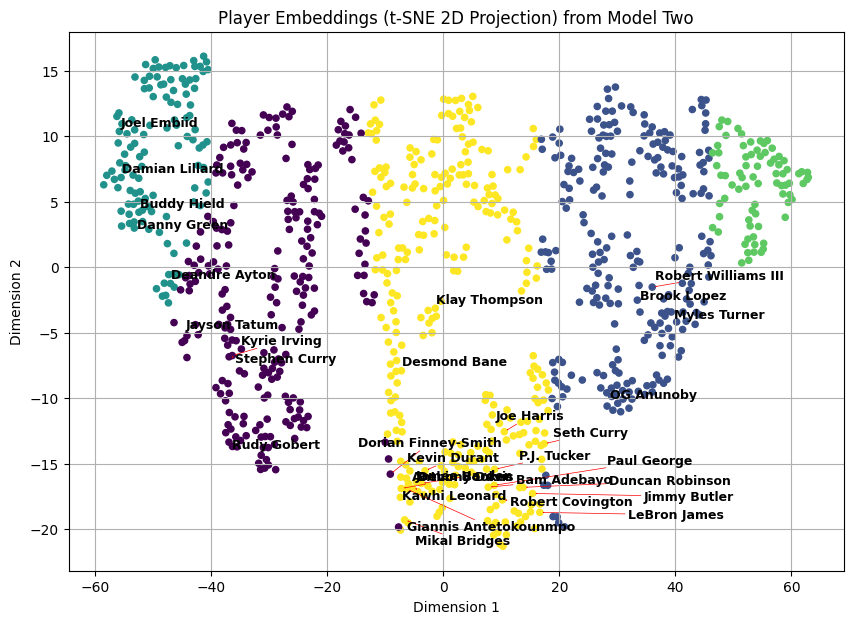

In [5]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from nba_api.stats.static import players
from adjustText import adjust_text

##############################################
# Extract and Save Player Embeddings
##############################################
# The embedding layer is named 'player_embedding', get its weights
embedding_matrix = model.get_layer('player_embedding').get_weights()[0]

# player_to_index maps player_id -> index, we need the reverse mapping for output
index_to_player = {i: p for p, i in player_to_index.items()}

# Create a DataFrame for player embeddings
embedding_dim = embedding_matrix.shape[1]
columns = ['player_id'] + [f'embed_{d}' for d in range(embedding_dim)]

data = []
for i in range(len(index_to_player)):
    player_id = index_to_player[i]
    row = [player_id] + embedding_matrix[i].tolist()
    data.append(row)

df_emb = pd.DataFrame(data, columns=columns)

# Save to a CSV file
df_emb.to_csv('player_embeddings_two.csv', index=False)

##############################################
# Load the CSV and Plot Using t-SNE
##############################################
df = pd.read_csv('player_embeddings_two.csv')
player_ids = df['player_id'].values
embedding_cols = [c for c in df.columns if c.startswith('embed_')]
vectors = df[embedding_cols].values

# Run TSNE on vectors
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(vectors)

x_coords = tsne_coords[:, 0]
y_coords = tsne_coords[:, 1]

# Perform K-Means clustering (optional, for color)
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(vectors)

# Get NBA players list and create a dict id->full_name
all_nba_players = players.get_players()
id_to_name = {p['id']: p['full_name'] for p in all_nba_players}

plt.figure(figsize=(10, 7))
plt.scatter(x_coords, y_coords, s=20, c=cluster_labels, cmap='viridis')

texts = []

# Define a set of famous players including centers, 3&D, and shooters (adjust as desired)
famous_players = {
    "LeBron James", "Stephen Curry", "Kevin Durant", "Giannis Antetokounmpo", 
    "James Harden", "Kawhi Leonard", "Anthony Davis", "Nikola Jokic", 
    "Joel Embiid", "Luka Doncic", "Damian Lillard", "Jayson Tatum", 
    "Devin Booker", "Jimmy Butler", "Kyrie Irving", "Paul George",
    "Rudy Gobert", "Brook Lopez", "Mikal Bridges", "Klay Thompson",
    "Bam Adebayo", "Myles Turner", "Jonas Valanciunas", "Deandre Ayton", "Robert Williams III",
    "P.J. Tucker", "Robert Covington", "Danny Green", "Dorian Finney-Smith", "OG Anunoby",
    "Joe Harris", "Buddy Hield", "Duncan Robinson", "Seth Curry", "Desmond Bane"
}

# Label only famous players if they appear
for i, pid in enumerate(player_ids):
    player_name = id_to_name.get(pid, None)
    if player_name in famous_players:
        # Label this famous player
        text_obj = plt.text(x_coords[i], y_coords[i], player_name, fontsize=9, fontweight='bold')
        texts.append(text_obj)

plt.title("Player Embeddings (t-SNE 2D Projection) from Model Two")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)

# Adjust text positions to avoid overlap
if texts:
    labeled_x = [t.get_position()[0] for t in texts]
    labeled_y = [t.get_position()[1] for t in texts]
    adjust_text(texts, x=labeled_x, y=labeled_y, arrowprops=dict(arrowstyle='->', color='red', lw=0.5))

plt.show()